# IEEE Fraud Detect: part 03:
## Trying out Machine learning models

In [1]:
import os
import gc
gc.enable()
import time

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
# Loading the normalized reduced dataset for training
train_data = pd.read_parquet(os.getcwd() + '\\pca_num_train.gzip')
target = pd.read_parquet(os.getcwd() + '\\target_var.gzip')

In [3]:
# Only load for prediction or later for manipulaiton:
# test_data = pd.read_parquet(os.getcwd() + '\\Data\\test.gzip')

# Testing out Random Forest Classification: on imbalanced dataset

Sources:
- https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

In [4]:
# Split into 70% training and 30% validation set. Taking a bit more in validation set as data is highly imbalanced.
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(train_data, target, 
                                        test_size = 0.3, 
                                        random_state = 10)

In [5]:
from sklearn.ensemble import RandomForestClassifier

RSEED = 100 # defining random seed for reproducibility

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=20, 
                               random_state=RSEED, 
                               max_features = 'auto',
                               bootstrap= True,
                               oob_score= True,
                               class_weight = None, # None, balanced
                               verbose = 1) # n_jobs=-1 # means using all processors for parallel use

# Fit on training data
model.fit(X.values, y.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


RandomForestClassifier(n_estimators=20, oob_score=True, random_state=100,
                       verbose=1)

In [6]:
# We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 10 trees in the forest.

n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 21231
Average maximum depth 61


In [7]:
# Random forest results

train_rf_predictions = model.predict(X.values)
train_rf_probs = model.predict_proba(X.values)[:, 1]

rf_predictions = model.predict(X_val.values)
rf_probs = model.predict_proba(X_val.values)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.7s finished


In [8]:

def evaluate_model(predictions, probs, train_predictions, train_probs, test_labels, train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, plot_precision_recall_curve, plot_roc_curve, precision_recall_curve
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    

In [9]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, y_val, y)

Recall Baseline: 1.0 Test: 0.38 Train: 0.91
Precision Baseline: 0.04 Test: 0.86 Train: 1.0
Roc Baseline: 0.5 Test: 0.86 Train: 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


Text(0.5, 1.0, 'Confusion Matrix')

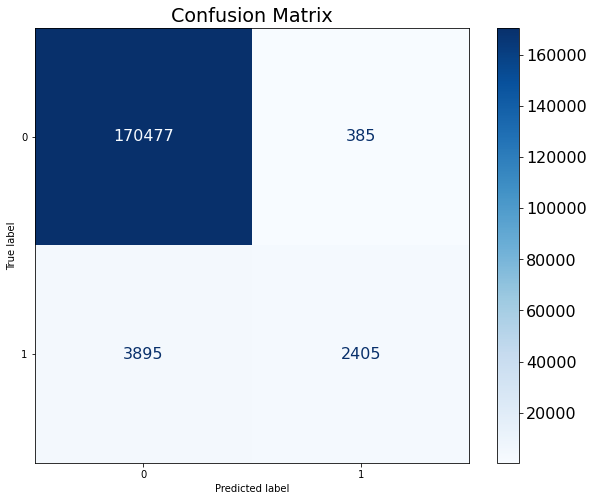

In [13]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(model, X_val, y_val,normalize=None, display_labels=None, include_values=True, xticks_rotation='horizontal', values_format=None, cmap=plt.cm.Blues, colorbar=True, ax = ax)   
disp.ax_.set_title('Confusion Matrix')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


Text(0.5, 1.0, 'ROC curve')

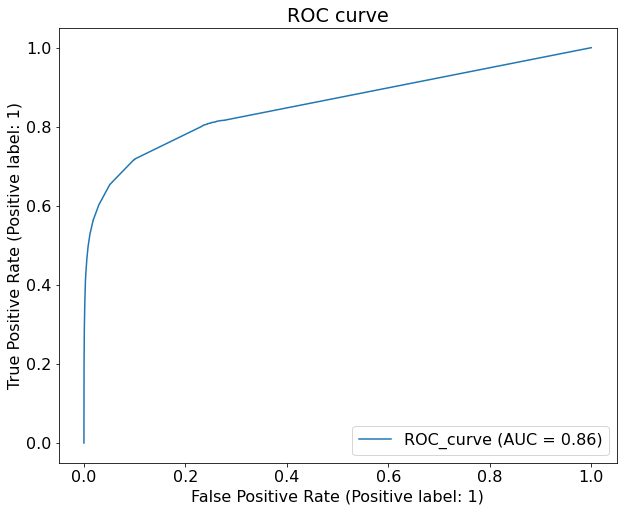

In [14]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/
# https://dl.acm.org/doi/10.1145/1143844.1143874


from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.size'] = 16
disp = plot_roc_curve(model, X_val, y_val, pos_label=model.classes_[1], ax = ax, name="ROC_curve")   
disp.ax_.set_title('ROC curve')

## Here only precision and recall makes sense for very highly skewed dataset.
### - As they are not effected by the majority class, they tend to show more true result compared to ROC and accuracy.
### - Precision = TP / (TP + FP) : Out of all the predicted frauds, how much of it is really "true"? High precision is desired.
### - Recall = TP / (FN + TP) : Out of all the "true" frauds how much the model was able to predict correctly? High recall is also desired.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.8s finished


Text(0.5, 1.0, 'Precision-Recall curve (AUC = 0.63)')

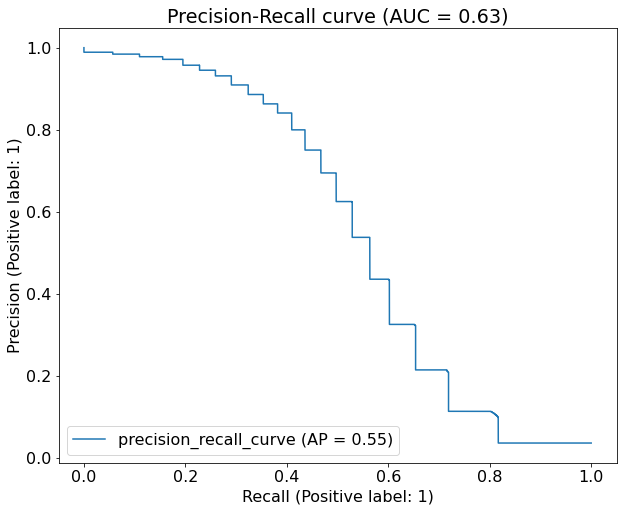

In [15]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve, auc
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.size'] = 16
disp = plot_precision_recall_curve(model, X_val, y_val, pos_label=model.classes_[1], ax = ax, name="precision_recall_curve")    

precision, recall, thresholds = precision_recall_curve(y_val, rf_predictions, pos_label=model.classes_[1])

disp.ax_.set_title('Precision-Recall curve (AUC = {0:0.2f})'.format(auc(recall, precision)))
